# PME3481 - Controle e Aplicações

## Síntese pelo LQR - Regulador Linear Quadrático

Aqui, o objetivo é encontrar o LQR, bem como realizar o estudo da estabilidade segundo o critério de Lyapunov, e apresentar isso de forma concisa.

In [14]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ctrl
import warnings

In [15]:
warnings.simplefilter("ignore")  # Ignore all warnings

### Estabilidade segundo Lyapunov

A função de Lyapunov \(V(x)\) é positiva definida e contínua, com $V(x_e) = 0$ no ponto de equilíbrio $x_e$. A estabilidade do ponto de equilíbrio é então analisada observando o sinal de sua derivada ao longo das trajetórias do sistema.

Se a derivada da função de Lyapunov ao longo das trajetórias do sistema for negativa definida em uma vizinhança do ponto de equilíbrio, ou seja,

$$
\dot{V}(x) = \frac{{dV}}{{dt}} < 0, \quad \text{para} \quad x \neq x_e
$$

então o ponto de equilíbrio é considerado estável. Se $\dot{V}(x) < 0$ em uma vizinhança do ponto de equilíbrio e $\dot{V}(x) = 0$ apenas no ponto de equilíbrio, então o ponto de equilíbrio é assintoticamente estável.

In [16]:
def check_stability(A):
    """
    Check system stability using Lyapunov's method.
    
    Parameters:
        A (numpy.ndarray): State matrix.
    
    Returns:
        stable (bool): True if the system is stable, False otherwise.
    """
    # Solve the Lyapunov equation A.T @ P + P @ A = -I
    P = la.solve_lyapunov(A.T, -np.eye(A.shape[0]))
    
    # Check if the solution is positive definite
    stable = np.all(np.linalg.eigvals(P) > 0)
    return stable

### Definição das Funções e Organização

Função que retorna a matriz de ganho K segundo as penalizações defindias em Q e R, que indicam quais variáveis de estados devem ser consideradas mais importantes.

In [17]:
def lqr(A, B, Q, R):
    """    
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.
    
    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = np.linalg.inv(R) @ B.T @ P
    return K

Definição do modelo dinâmico linear do foguete, que permite realizar os testes com as funções desenvolvidas acima.

In [18]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0

# X = [x,y,theta,xp,yp,thetap]
# Xp = [xp,yp,thetap,xpp,ypp,thetapp]
A = np.array([[0, 0, 0, 1],
              [(1/M)*((1/2)*dar*Cd*Vxlin**2*L*Df), (1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [(1/M)*(-M*g+(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2)), 0, 0, 0],
              [(1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)), 0, 0, 0]])

B = np.array([[0, 0],
              [1/M, 0],
              [0, -Tlin/M],
              [0, -Tlin*Xcm/Izz]])

C = np.array([[ 1, 0, 0, 0],
              [ 0, 1, 0, 0],
              [ 0, 0, 1, 0],
              [ 0, 0, 0, 1]])

D = np.array([[ 0, 0],
              [ 0, 0],
              [ 0, 0],
              [ 0, 0]])     

### Estudo da Estabilidade

In [19]:
stable = check_stability(A)
if stable:
    print("The system is stable according to Lyapunov's method.")
else:
    print("The system is unstable according to Lyapunov's method.")

The system is unstable according to Lyapunov's method.


### LQR

Definição das matrizes de custo - associadas à função de perda do LQR.

In [20]:
# Define Q, R matrices (cost matrices)
# Define state cost matrix Q
Q = np.diag([10, 50, 10, 30])  # Higher importance to amgular-related states

# State cost matrix
R = np.diag([0.1, 100])  # Moderate penalty for control inputs

In [21]:
# Compute LQR controller
K = lqr(A, B, Q, R)

np.set_printoptions(precision=3, suppress=True)
print("LQR Feedback Gain Matrix (K):")
print(K)

LQR Feedback Gain Matrix (K):
[[ 1.227 22.276  0.473 -0.199]
 [-2.51  -0.033  0.316 -0.998]]


O sistema em malha fechada fica da seguinte forma:

In [22]:
# Compute closed-loop system
Acl = A - np.dot(B, K)
syscl = ctrl.ss(Acl, B, C, D)
syscl

<LinearIOSystem:sys[3]:['u[0]', 'u[1]']->['y[0]', 'y[1]', 'y[2]', 'y[3]']>

In [23]:
u = [0, 0]
X0  = [0.1, 10, 0, 0]
tempo = np.linspace(0, 90, 400000)

t, amp,yr = ctrl.forced_response(syscl, tempo, 0 ,X0,return_x = 'True')

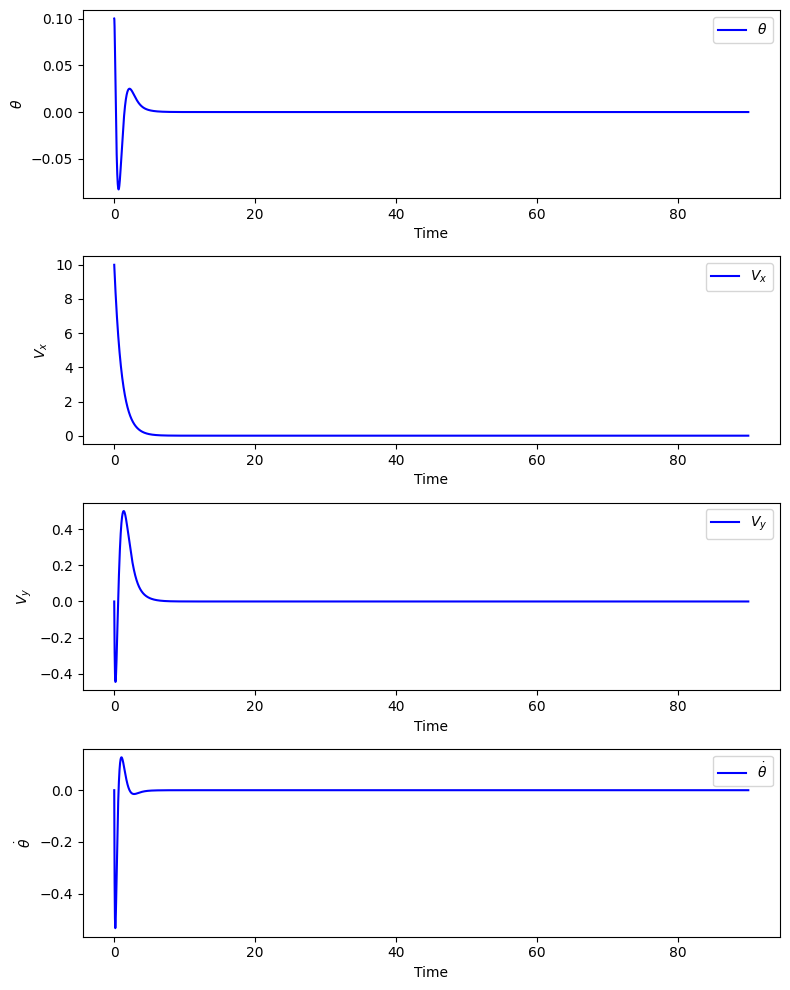

In [24]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

# Plot Theta
axes[0].plot(t, yr[0], color='blue')
axes[0].set_ylabel(r'$\theta$')
axes[0].set_xlabel('Time')
axes[0].legend([r'$\theta$'], loc='upper right')

# Plot VX
axes[1].plot(t, yr[1], color='blue')
axes[1].set_ylabel(r'$V_x$')
axes[1].set_xlabel('Time')
axes[1].legend([r'$V_x$'], loc='upper right')

# Plot Vy
axes[2].plot(t, yr[2], color='blue')
axes[2].set_ylabel(r'$V_y$')
axes[2].set_xlabel('Time')
axes[2].legend([r'$V_y$'], loc='upper right')

# Plot Thetap
axes[3].plot(t, yr[3], color='blue')
axes[3].set_ylabel(r'$\dot{\theta}$')
axes[3].set_xlabel('Time')
axes[3].legend([r'$\dot{\theta}$'], loc='upper right')

plt.tight_layout()
plt.show()

In [25]:
u = np.dot(-K,yr)

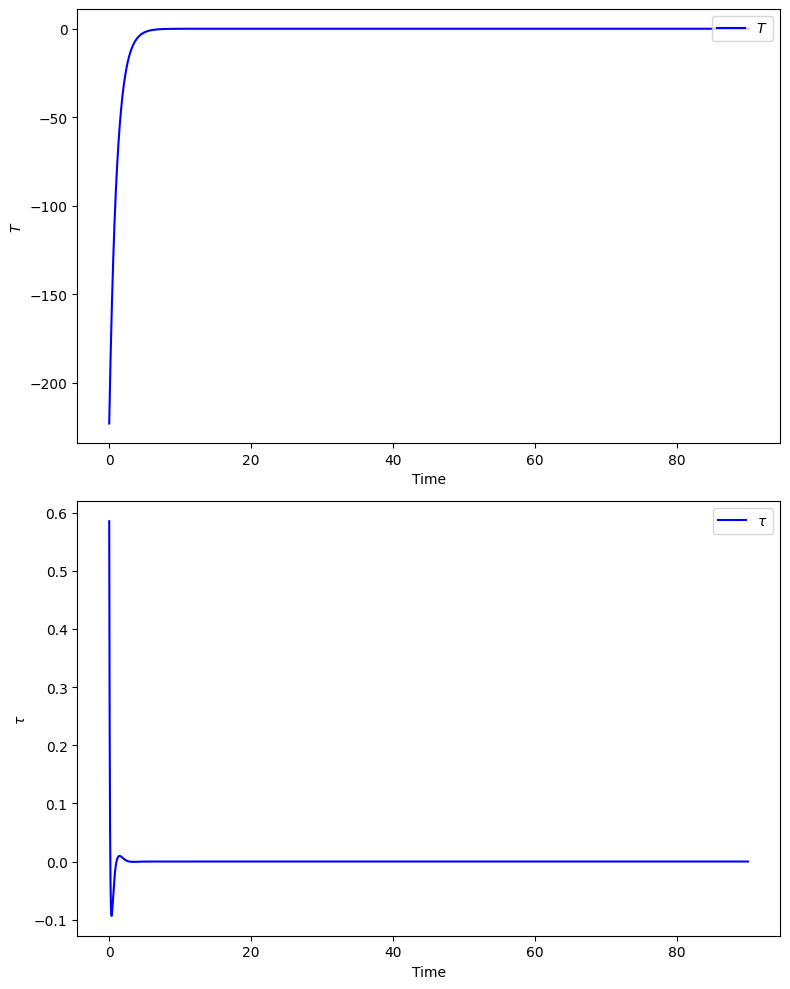

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot Theta
axes[0].plot(t, u[0], color='blue')
axes[0].set_ylabel(r'$T$')
axes[0].set_xlabel('Time')
axes[0].legend([r'$T$'], loc='upper right')

# Plot VX
axes[1].plot(t, u[1], color='blue')
axes[1].set_ylabel(r'$\tau$')
axes[1].set_xlabel('Time')
axes[1].legend([r'$\tau$'], loc='upper right')

plt.tight_layout()
plt.show()